# Preparing Dataset

upload and check dataset on colab

In [1]:
import os
import zipfile
import tensorflow as tf
import tensorflow_hub as hub
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
cwd = os.getcwd()
print(cwd)

!unzip Skin-disease.zip 


N:\A PROJECT S1\Semester 6\1. BANGKIT\Capstone ML\Capstone-Bangkit-ML


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# describe training and validation directory
base_dir = './Skin-disease'

train_dir = os.path.join(base_dir, 'Train')
valid_dir = os.path.join(base_dir, 'Valid')

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224,224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(valid_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224,224))


Found 140 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


# Building model with Transfer Learning


In [8]:
do_fine_tuning = True #@param {type:"boolean"}

if do_fine_tuning:
    feature_extractor.trainable = True    
else:
    feature_extractor.trainable = False

In [4]:
#@title Default title text
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMAGE_SIZE =(224,224)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,))


model = tf.keras.Sequential([
        hub.KerasLayer(MODULE_HANDLE,
                       input_shape=IMAGE_SIZE + (3,)),
        tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

NameError: ignored

In [6]:
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMAGE_SIZE =(224,224)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,))

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Train model with datset

In [9]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=15)

Epoch 1/15
7/7 [==============================] - 14s 222ms/step - loss: 0.6965 - accuracy: 0.6143 - val_loss: 0.6051 - val_accuracy: 0.7000
Epoch 2/15
7/7 [==============================] - 1s 113ms/step - loss: 0.3836 - accuracy: 0.8857 - val_loss: 0.6064 - val_accuracy: 0.8000
Epoch 3/15
7/7 [==============================] - 1s 109ms/step - loss: 0.3042 - accuracy: 0.9143 - val_loss: 0.7479 - val_accuracy: 0.6333
Epoch 4/15
7/7 [==============================] - 1s 108ms/step - loss: 0.2411 - accuracy: 0.9143 - val_loss: 0.5891 - val_accuracy: 0.7667
Epoch 5/15
7/7 [==============================] - 1s 110ms/step - loss: 0.1849 - accuracy: 0.9286 - val_loss: 0.6488 - val_accuracy: 0.7667
Epoch 6/15
7/7 [==============================] - 1s 113ms/step - loss: 0.1531 - accuracy: 0.9500 - val_loss: 0.6989 - val_accuracy: 0.7333
Epoch 7/15
7/7 [==============================] - 1s 111ms/step - loss: 0.1271 - accuracy: 0.9714 - val_loss: 0.6280 - val_accuracy: 0.7667
Epoch 8/15
7/7 [===

# Evaluate train model

Text(0.5, 1.0, 'Training and validation loss')

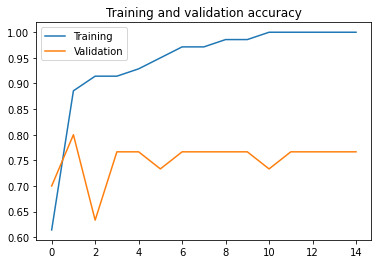

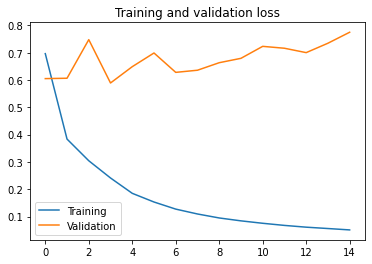

In [10]:
import matplotlib.pyplot as plt


acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs


plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

# Export Model



In [11]:
two_skin_disease = 'two_skin_disease'

In [12]:
tf.saved_model.save(model, two_skin_disease)

INFO:tensorflow:Assets written to: two_skin_disease/assets


INFO:tensorflow:Assets written to: two_skin_disease/assets


In [14]:
%%bash -s $two_skin_disease
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [15]:
loaded = tf.saved_model.load(two_skin_disease)

In [16]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


# Convert to TFLite and Download

In [17]:
converter = tf.lite.TFLiteConverter.from_saved_model(two_skin_disease)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [18]:
tflite_model_file = '2skin_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [22]:
class_names = ['chickenpox','scabies']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [23]:
try:
    from google.colab import files
    files.download('2skin_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>